In [1]:
import sys
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt, markers
from pprint import pprint
import json
from tabulate import tabulate

ROOT = Path().absolute()
DATASETS_PATH = ROOT / "hloc/pipelines/Blender_Synthetic/datasets"
SFM_PATH = ROOT / "hloc/pipelines/Blender_Synthetic/out"

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))


class color:
    PURPLE = "\033[95m"
    CYAN = "\033[96m"
    DARKCYAN = "\033[36m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    END = "\033[0m"

In [2]:
def is_hfnet_dataset(ds_name):
    return ds_name.startswith("LOC-")

# read stats for datasets
datasets_stats = []
for p in DATASETS_PATH.rglob("stats.json"):
    ds_name = p.parent.name
    #print(f"  {ds_name}")
    with open(p, "r", encoding="utf8") as f:
        data = json.load(f)
    datasets_stats.append((data, ds_name))

print(f"found {len(datasets_stats)} dataset stats")
# pprint(datasets_stats)

hfnet_prefix = "LOC-"
# read stats for sfm results
sfm_stats = []
sfm_loc_stats = []
for p in SFM_PATH.rglob("stats.json"):
    ds_name = p.parent.parent.parent.name
    sfm_method = p.parent.name.removeprefix(ds_name).removeprefix("-")
    #print(f"  {ds_name} - {sfm_method}")
    with open(p, "r", encoding="utf8") as f:
        data = json.load(f)
    if is_hfnet_dataset(ds_name):
        sfm_loc_stats.append((data, ds_name, sfm_method))
    else:
        sfm_stats.append((data, ds_name, sfm_method))

print(f"found {len(sfm_stats)} sfm stats")
print(f"found {len(sfm_loc_stats)} sfm HF-Net stats")
# pprint(sfm_stats)

found 12 dataset stats
found 35 sfm stats
found 30 sfm HF-Net stats


In [3]:
PLACEHOLDER = "-"

# analyse ds stats
table = []
for data, ds_name in datasets_stats:
    c2c_stats = [x for x in data["stats"] if x["full_name"] == "Average Camera to Camera Centroid Distance"]
    c2c_stats = c2c_stats[0] if len(c2c_stats) > 0 else None
    baseline_stats = [x for x in data["stats"] if x["full_name"] == "Min and Max View Baseline"]
    baseline_stats = baseline_stats[0] if len(baseline_stats) > 0 else None
    table.append(
        [
            f'{data["scene_name"]} ({data["env_background"]})',
            data["num_cameras"],
            PLACEHOLDER if not c2c_stats else f'{c2c_stats["value"]:.2f}',
            PLACEHOLDER if not baseline_stats else f'{baseline_stats["min"]:.2f}',
            PLACEHOLDER if not baseline_stats else f'{baseline_stats["max"]:.2f}',
        ]
    )

print(
    tabulate(
        table,
        [
            "name",
            "cams",
            "avg. c2c centroid dist (m)",
            "min view dist (m)",
            "max view dist (m)",
        ],
        tablefmt="plain",
        showindex="always",
    )
)

    name                              cams    avg. c2c centroid dist (m)    min view dist (m)    max view dist (m)
 0  Bartholomew (evening_field_8k)      10                          4.39                 2.43                14.42
 1  Chateu (evening_field_8k)           15                         11.26                 2.71                32.2
 2  Chateu (evening_field_8k)           15                         11.26                 2.71                32.2
 3  Chateu (evening_field_8k)           15                         11.26                 2.71                32.2
 4  Framlingham (evening_field_8k)      10                         11.07                 4.22                39.68
 5  Bartholomew (evening_field_8k)      10                          4.39                 2.43                14.42
 6  Chateu (evening_field_8k)           15                         11.26                 2.71                32.2
 7  Chateu (evening_field_8k)           15                         11.26            

In [4]:
# analyse ds stats
def get_analysis_table(sfm_stats):
    table = []
    for data, ds_name, sfm_method in sfm_stats:
        if "result" in data and data["result"] == "error":
            table.append(
                [
                    ds_name,
                    f"{sfm_method} *",
                    PLACEHOLDER,
                    PLACEHOLDER,
                    PLACEHOLDER,
                    PLACEHOLDER,
                    PLACEHOLDER,
                    PLACEHOLDER,
                    PLACEHOLDER,
                ]
            )
            continue
        t_errs = np.array([i["t_err_m"] for i in data["analysed_poses"]])
        r_errs = np.array([i["r_err_deg"] for i in data["analysed_poses"]])
        re_errs = np.array([i["reprojection_err"] for i in data["analysed_poses"]])
        t_errs_med = np.median(t_errs)
        r_errs_med = np.median(r_errs)
        loc = [i for i in data["analysed_poses"] if "MAIN" in i["name"]][0]
        loc_t_err = loc["t_err_m"]
        loc_r_err = loc["r_err_deg"]
        re_errs_med = np.median(re_errs)
        loc_abs_ground_distance = loc["ground_distance_m"]

        # ratios
        t_errs_size = t_errs.size
        r_errs_size = r_errs.size
        t_ratio = t_errs[t_errs < 1].size / t_errs_size
        r_ratio = r_errs[r_errs < 5].size / r_errs_size

        table.append(
            [
                ds_name,
                sfm_method,
                f"{re_errs_med:.2f}",
                f"{t_errs_med:.2f}",
                f"{r_errs_med:.2f}",
                f"{loc_t_err:.2f}",
                f"{loc_r_err:.2f}",
                f"{loc_abs_ground_distance:.2f}",
                # f"{t_ratio:.2f}",
                # f"{r_ratio:.2f}",
            ]
        )

    columns = [
        "dataset",
        "feature pipeline",
        "med. reprojection error (px)",  # median, because main cam is outlier
        "med. t_err (m)",
        "med. r_err (°)",
        "localized camera t_err (m)",
        "localized camera r_err (°)",
        "distance to ground (m)",
        # "t_err (x < 1px)",
        # "r_err (x < 5°)",
    ]

    return table, columns


sfm_stats_table, sfm_stats_table_cols = get_analysis_table(sfm_stats)

print(
    tabulate(
        sfm_stats_table,
        sfm_stats_table_cols,
        tablefmt="plain",
        showindex="always",
    ),
    "\n\n* this method failed to localize the camera",
)

    dataset                       feature pipeline        med. reprojection error (px)    med. t_err (m)    med. r_err (°)    localized camera t_err (m)    localized camera r_err (°)    distance to ground (m)
 0  Bartholomew+evening_field_8k  disk+lightglue          0.87                            0.03              0.21              1.29                          2.39                          1.11
 1  Bartholomew+evening_field_8k  loftr                   0.60                            0.01              0.05              1.58                          2.17                          0.88
 2  Bartholomew+evening_field_8k  r2d2+nn_mutual          1.47                            0.05              0.25              2.34                          3.48                          0.34
 3  Bartholomew+evening_field_8k  superpoint+lightglue    1.12                            0.02              0.21              4.97                          1.62                          0.97
 4  Bartholomew+evening_fie

In [5]:
# bold text below certain threshold
def bold_print_threshold(value: float, threshold: float = None):
    f_value = f"{value:.2f}"
    if not threshold or value < threshold:
        return f"{color.BOLD}{f_value}{color.END}"
    return f_value


# aggregate hfnet and non-hfnet stats for comparison
sfm_hfnet_stats_table = []
sfm_hfnet_stats_table_cols = [
    "DS Name",
    "feature pipeline",
    "localized camera t_err (m)",
    "localized camera r_err (°)",
    "distance to ground (m)",
]

for i, stat in enumerate(sfm_stats):
    stat_ds_data = stat[0]
    stat_ds_name = stat[1]
    stat_ds_method = stat[2]

    matching_hfnet_stat = None
    for j, hfnet_stat in enumerate(sfm_loc_stats):
        hfnet_ds_name = hfnet_stat[1]
        hfnet_ds_method = hfnet_stat[2]

        if stat_ds_name in hfnet_ds_name and stat_ds_method == hfnet_ds_method:
            matching_hfnet_stat = hfnet_stat
            break

    # if matching_hfnet_stat:
    #    print(f"found matching HF-Net stats for {stat_ds_name} / {matching_hfnet_stat[1]} for method {stat_ds_method} / {matching_hfnet_stat[2]}")
    # else:
    #    print(f"no matching HF-Net stats for {stat_ds_name} for method {stat_ds_method}")

    A_stats = []
    B_stats = []

    # A stats for SFM
    if "result" in stat_ds_data and stat_ds_data["result"] == "error":
        A_stats = [PLACEHOLDER, PLACEHOLDER, PLACEHOLDER]
    else:
        loc = [i for i in stat_ds_data["analysed_poses"] if "MAIN" in i["name"]][0]
        loc_t_err = loc["t_err_m"]
        loc_r_err = loc["r_err_deg"]
        loc_abs_ground_distance = loc["ground_distance_m"]
        A_stats = [
            f"{loc_t_err:.2f}",
            f"{loc_r_err:.2f}",
            f"{loc_abs_ground_distance:.2f}",
        ]

    # B stats for HF-Net
    if (
        matching_hfnet_stat is None
        or "result" in matching_hfnet_stat[0]
        and matching_hfnet_stat[0]["result"] == "error"
    ):
        B_stats = [PLACEHOLDER, PLACEHOLDER, PLACEHOLDER]
    else:
        hfnet_data = matching_hfnet_stat[0]
        hfnet_loc = [i for i in hfnet_data["analysed_poses"] if "MAIN" in i["name"]][0]
        hfnet_loc_t_err = hfnet_loc["t_err_m"]
        hfnet_loc_r_err = hfnet_loc["r_err_deg"]
        hfnet_loc_abs_ground_distance = hfnet_loc["ground_distance_m"]
        B_stats += [
            f"{hfnet_loc_t_err:.2f}",
            f"{hfnet_loc_r_err:.2f}",
            f"{hfnet_loc_abs_ground_distance:.2f}",
        ]

    # combine row general info with stats from A and B
    row = [stat_ds_name, stat_ds_method]  # partial row
    for a, b in zip(A_stats, B_stats):
        row.append(f"{a} / {b}")

    sfm_hfnet_stats_table.append(row)

print(
    tabulate(
        sfm_hfnet_stats_table,
        sfm_hfnet_stats_table_cols,
        tablefmt="plain",
        showindex="always",
    )
)

    DS Name                       feature pipeline      localized camera t_err (m)    localized camera r_err (°)    distance to ground (m)
 0  Bartholomew+evening_field_8k  disk+lightglue        1.29 / 0.78                   2.39 / 1.79                   1.11 / 1.15
 1  Bartholomew+evening_field_8k  loftr                 1.58 / 41.59                  2.17 / 211.93                 0.88 / 7.72
 2  Bartholomew+evening_field_8k  r2d2+nn_mutual        2.34 / 0.75                   3.48 / 1.55                   0.34 / 1.41
 3  Bartholomew+evening_field_8k  superpoint+lightglue  4.97 / 0.93                   1.62 / 2.14                   0.97 / 1.04
 4  Bartholomew+evening_field_8k  superpoint+superglue  4.12 / 1.00                   1.64 / 2.42                   1.00 / 0.93
 5  Chateu-img1+evening_field_8k  disk+lightglue        - / 31.33                     - / 97.72                     - / 10.28
 6  Chateu-img1+evening_field_8k  loftr                 - / 136.20                    - / 61.41

{'disk+lightglue': '^',
 'loftr': 's',
 'r2d2+nn_mutual': '*',
 'superpoint+lightglue': 'D',
 'superpoint+superglue': 'o'}
dict_items([('superpoint+superglue', 'o'), ('r2d2+nn_mutual', '*'), ('disk+lightglue', '^'), ('loftr', 's'), ('superpoint+lightglue', 'D')])


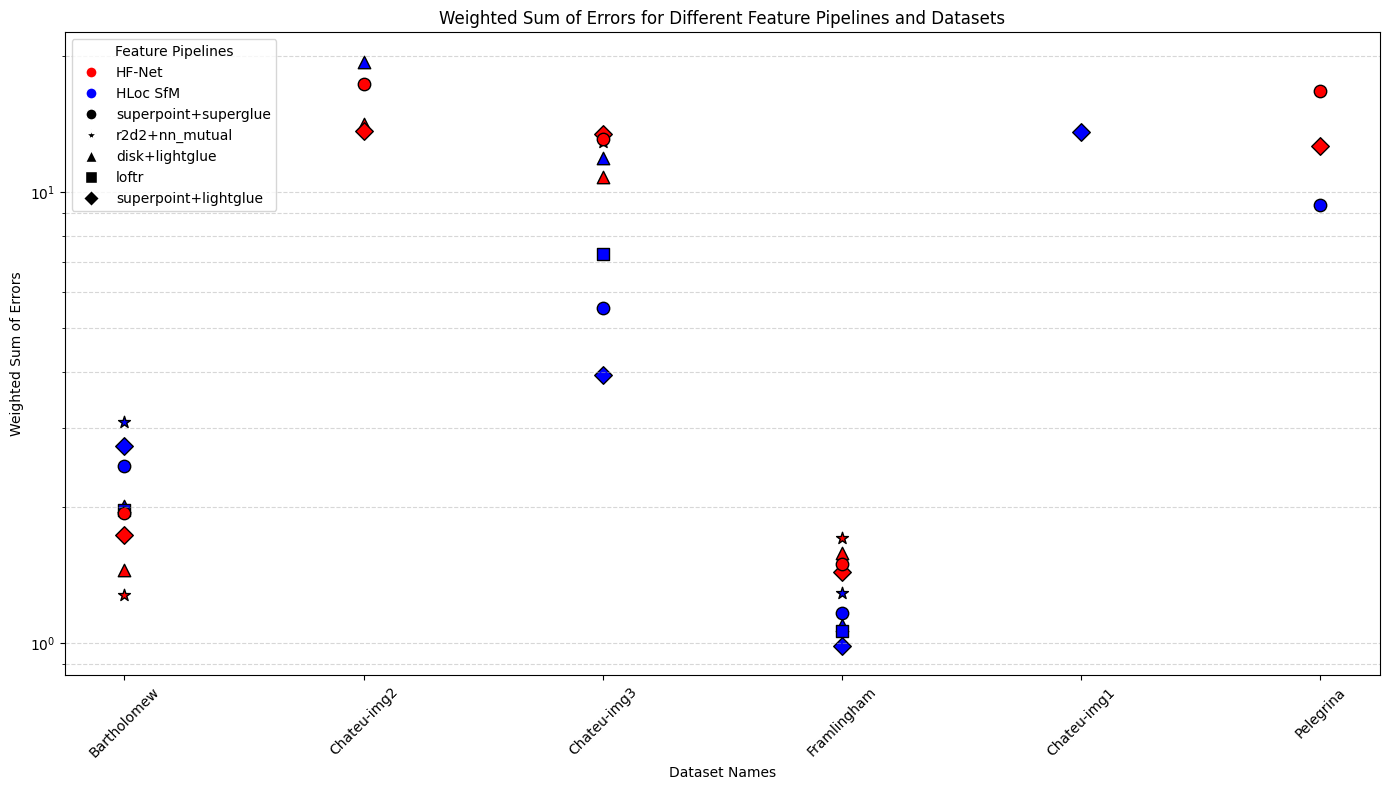

In [6]:
# We will slightly modify the logic to ensure the correct mapping of dataset names to each weighted sum

w_t = 1 / 3
w_r = 2 / 3
#w_t = 1
#w_r = 1
# Collecting data for the graph
sfm_hfnet_stats_table = []
symbols = ["o", "*", "^", "s", "D", "4", "p", "v", ">", "x", "+"]
# symbols = list(markers.MarkerStyle.markers.keys())[:25]
MAX_ERROR = 50

for i, stat in enumerate(sfm_stats):
    stat_ds_data = stat[0]
    stat_ds_name = stat[1]
    stat_ds_method = stat[2]

    matching_hfnet_stat = None
    for j, hfnet_stat in enumerate(sfm_loc_stats):
        hfnet_ds_name = hfnet_stat[1]
        hfnet_ds_method = hfnet_stat[2]

        if stat_ds_name in hfnet_ds_name and stat_ds_method == hfnet_ds_method:
            matching_hfnet_stat = hfnet_stat
            break

    A_stats = []
    B_stats = []

    # A stats for SFM
    if "result" in stat_ds_data and stat_ds_data["result"] == "error":
        A_stats = [None, None, None]
    else:
        loc = [i for i in stat_ds_data["analysed_poses"] if "MAIN" in i["name"]][0]
        loc_t_err = loc["t_err_m"]
        loc_r_err = loc["r_err_deg"]
        loc_abs_ground_distance = loc["ground_distance_m"]
        A_stats = [loc_t_err, loc_r_err, loc_abs_ground_distance]

    # B stats for HF-Net
    if matching_hfnet_stat is None or (
        "result" in matching_hfnet_stat[0]
        and matching_hfnet_stat[0]["result"] == "error"
    ):
        B_stats = [None, None, None]
    else:
        hfnet_data = matching_hfnet_stat[0]
        hfnet_loc = [i for i in hfnet_data["analysed_poses"] if "MAIN" in i["name"]][0]
        hfnet_loc_t_err = hfnet_loc["t_err_m"]
        hfnet_loc_r_err = hfnet_loc["r_err_deg"]
        hfnet_loc_abs_ground_distance = hfnet_loc["ground_distance_m"]
        B_stats = [hfnet_loc_t_err, hfnet_loc_r_err, hfnet_loc_abs_ground_distance]

    # Combine row general info with stats from A and B
    row = [stat_ds_name, stat_ds_method]  # partial row
    for a, b in zip(A_stats, B_stats):
        row.append((a, b))

    sfm_hfnet_stats_table.append(row)

# Calculating the weighted sum
weighted_sums_A = []
weighted_sums_B = []
ds_names_A = []
ds_names_B = []
methods_A = []
methods_B = []

# each item like this:
"""
[
    ds_name,
    method,
    (t_err_A, t_err_B),
    (r_err_A, r_err_B),
    (dist_from_ground_A, dist_from_ground_B),
]
"""

for row in sfm_hfnet_stats_table:
    ds_name = row[0].split("+")[0]  # get only ds name without env map
    method = row[1]
    t_err_A, r_err_A = row[2][0], row[3][0]
    t_err_B, r_err_B = row[2][1], row[3][1]

    if t_err_A is not None and r_err_A is not None:
        weighted_sum_A = w_t * t_err_A + w_r * r_err_A
        if weighted_sum_A < MAX_ERROR:
            ds_names_A.append(ds_name)
            methods_A.append(method)  # + ' A')
            weighted_sums_A.append(weighted_sum_A)

    if t_err_B is not None and r_err_B is not None:
        weighted_sum_B = w_t * t_err_B + w_r * r_err_B
        if weighted_sum_B < MAX_ERROR:
            ds_names_B.append(ds_name)
            methods_B.append(method)  # + ' B')
            weighted_sums_B.append(weighted_sum_B)

# Plotting
plt.figure(figsize=(14, 8))

all_methods = set(methods_A).union(set(methods_B))
mapped_symbols = {
    method: symbols[i % len(symbols)] for i, method in enumerate(all_methods)
}
pprint(mapped_symbols)

# Plot stats, but first make them a set so they are flattened and sort them, so the symbols are mapped correctly
# Plot A stats
shared_settings = {
    "s": 80,
    "edgecolors": "black",
}
for i, method in enumerate(sorted(set(methods_A))):
    subset = [x for j, x in enumerate(weighted_sums_A) if methods_A[j] == method]
    ds_subset = [x for j, x in enumerate(ds_names_A) if methods_A[j] == method]
    plt.scatter(
        ds_subset,
        subset,
        marker=mapped_symbols[method],
        label=method,
        color="b",
        **shared_settings
    )
    #pprint(ds_subset)
    #plt.annotate(f"TEST TEST TEST", xy=(ds_subset[0], subset[0]), xytext=(5, 5), textcoords='offset points', fontsize=8, color='green', arrowprops=dict(facecolor='green', shrink=0.05))

# Plot B stats
for i, method in enumerate(sorted(set(methods_B))):
    subset = [x for j, x in enumerate(weighted_sums_B) if methods_B[j] == method]
    ds_subset = [x for j, x in enumerate(ds_names_B) if methods_B[j] == method]
    plt.scatter(
        ds_subset,
        subset,
        marker=mapped_symbols[method],
        label=method,
        color="r",
        **shared_settings
    )

plt.yscale("log")
plt.xlabel("Dataset Names")
plt.ylabel("Weighted Sum of Errors")
plt.title("Weighted Sum of Errors for Different Feature Pipelines and Datasets")
plt.xticks(rotation=45)
# Adding gridlines with slight opacity
plt.grid(axis='y', linestyle='--', which='both', alpha=0.5)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], linewidth=4, marker='o', color="w", markersize=8, markerfacecolor='r', label="HF-Net"),
    Line2D([0], [0], linewidth=4, marker='o', color="w", markersize=8, markerfacecolor='b', label="HLoc SfM"),
]
legend_elements.extend(
    [
        Line2D([0], [0], marker=symbol, markerfacecolor="black", markersize=8, color="w", label=method)
        for method, symbol in mapped_symbols.items()
    ]
)
print(mapped_symbols.items())

# plt.legend(title="Feature Pipelines", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.legend(title="Feature Pipelines", handles=legend_elements, loc="upper left")
plt.tight_layout()

plt.show()

best method for Pelegrina: 7.547066067611725
best method for Chateu-img2: 13.439520917231551
best method for Framlingham: 0.9456695683986269
best method for Chateu-img1: 14.221330701496468
best method for Bartholomew: 1.3474632670343163
best method for Chateu-img3: 4.073964996799704


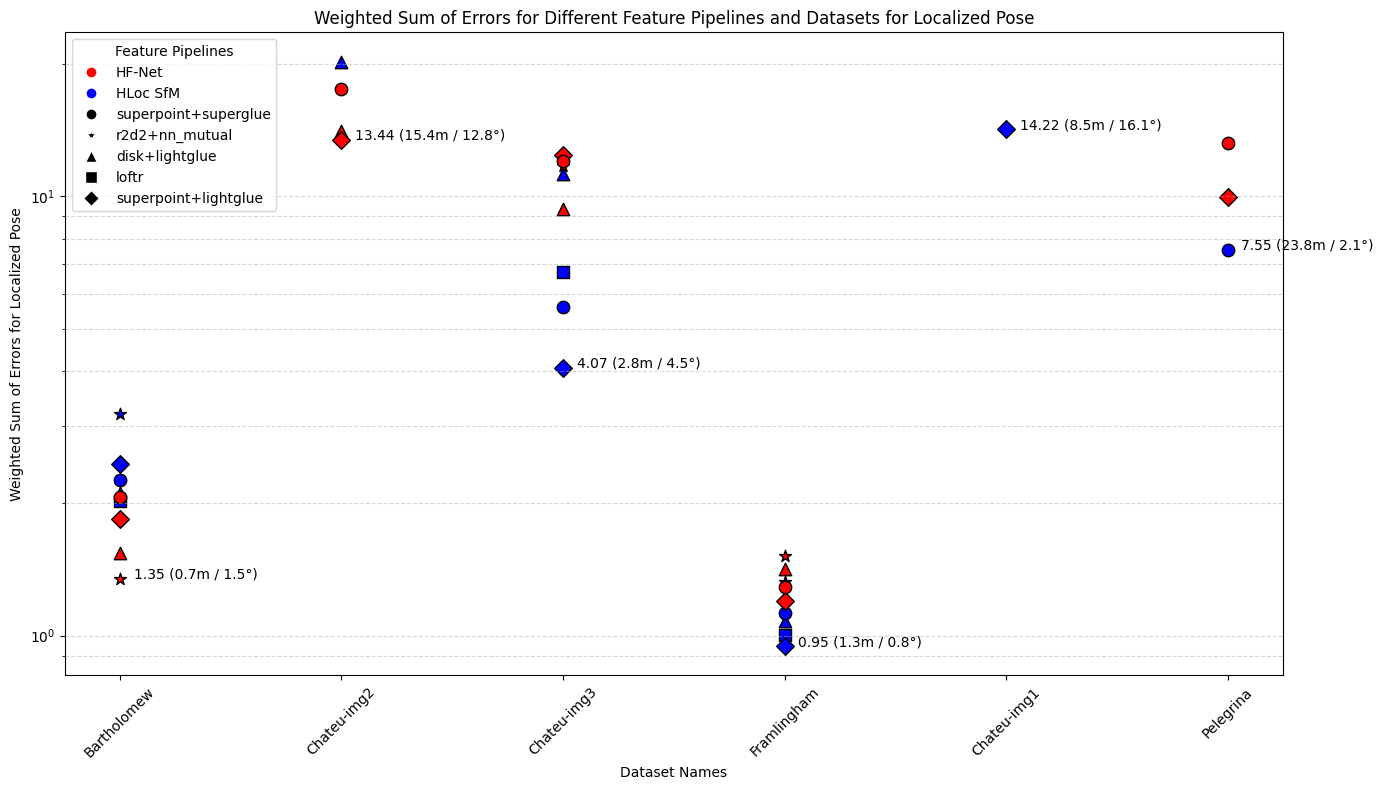

In [7]:
w_t = 1 / 4
w_r = 3 / 4
MAX_ERROR = 50

sfm_hfnet_stats_table = []
symbols = ["o", "*", "^", "s", "D", "4", "p", "v", ">", "x", "+"]


def weighted_sum(r, t):
    return w_t * t + w_r * r


for i, stat in enumerate(sfm_stats):
    stat_ds_data = stat[0]
    stat_ds_name = stat[1]
    stat_ds_method = stat[2]

    matching_hfnet_stat = None
    for j, hfnet_stat in enumerate(sfm_loc_stats):
        hfnet_ds_name = hfnet_stat[1]
        hfnet_ds_method = hfnet_stat[2]

        if stat_ds_name in hfnet_ds_name and stat_ds_method == hfnet_ds_method:
            matching_hfnet_stat = hfnet_stat
            break

    A_stats = []
    B_stats = []

    # A stats for SFM
    if "result" in stat_ds_data and stat_ds_data["result"] == "error":
        A_stats = [None, None, None]
    else:
        loc = [i for i in stat_ds_data["analysed_poses"] if "MAIN" in i["name"]][0]
        loc_t_err = loc["t_err_m"]
        loc_r_err = loc["r_err_deg"]
        loc_abs_ground_distance = loc["ground_distance_m"]
        A_stats = [loc_t_err, loc_r_err, loc_abs_ground_distance]

    # B stats for HF-Net
    if matching_hfnet_stat is None or (
        "result" in matching_hfnet_stat[0]
        and matching_hfnet_stat[0]["result"] == "error"
    ):
        B_stats = [None, None, None]
    else:
        hfnet_data = matching_hfnet_stat[0]
        hfnet_loc = [i for i in hfnet_data["analysed_poses"] if "MAIN" in i["name"]][0]
        hfnet_loc_t_err = hfnet_loc["t_err_m"]
        hfnet_loc_r_err = hfnet_loc["r_err_deg"]
        hfnet_loc_abs_ground_distance = hfnet_loc["ground_distance_m"]
        B_stats = [hfnet_loc_t_err, hfnet_loc_r_err, hfnet_loc_abs_ground_distance]

    # Combine row general info with stats from A and B
    row = [stat_ds_name.split("+")[0], stat_ds_method]  # partial row
    for a, b in zip(A_stats, B_stats):
        row.append((a, b))

    sfm_hfnet_stats_table.append(row)

# Calculating the weighted sum
weighted_sums_A = []
weighted_sums_B = []
ds_names_A = []
ds_names_B = []
methods_A = []
methods_B = []

for row in sfm_hfnet_stats_table:
    ds_name = row[0]
    method = row[1]
    t_err_A, r_err_A = row[2][0], row[3][0]
    t_err_B, r_err_B = row[2][1], row[3][1]

    if t_err_A is not None and r_err_A is not None:
        weighted_sum_A = weighted_sum(r_err_A, t_err_A)
        if weighted_sum_A < MAX_ERROR:
            ds_names_A.append(ds_name)
            methods_A.append(method)  # + ' A')
            weighted_sums_A.append(weighted_sum_A)

    if t_err_B is not None and r_err_B is not None:
        weighted_sum_B = weighted_sum(r_err_B, t_err_B)
        if weighted_sum_B < MAX_ERROR:
            ds_names_B.append(ds_name)
            methods_B.append(method)  # + ' B')
            weighted_sums_B.append(weighted_sum_B)


# Function to find the best and worst methods for each dataset
def find_best_worst_methods(stats_table):
    best_methods = {}
    worst_methods = {}
    for row in stats_table:
        ds_name = row[0]
        t_err_A, r_err_A = row[2][0], row[3][0]
        t_err_B, r_err_B = row[2][1], row[3][1]

        if t_err_A is not None and r_err_A is not None:
            weighted_sum_A = weighted_sum(r_err_A, t_err_A)
            if ds_name not in best_methods or weighted_sum_A < best_methods[ds_name][0]:
                best_methods[ds_name] = (weighted_sum_A, t_err_A, r_err_A, row[1])
            if (
                ds_name not in worst_methods
                or weighted_sum_A > worst_methods[ds_name][0]
            ):
                worst_methods[ds_name] = (weighted_sum_A, t_err_A, r_err_A, row[1])

        if t_err_B is not None and r_err_B is not None:
            weighted_sum_B = weighted_sum(r_err_B, t_err_B)
            if ds_name not in best_methods or weighted_sum_B < best_methods[ds_name][0]:
                best_methods[ds_name] = (weighted_sum_B, t_err_B, r_err_B, row[1])
            if (
                ds_name not in worst_methods
                or weighted_sum_B > worst_methods[ds_name][0]
            ):
                worst_methods[ds_name] = (weighted_sum_B, t_err_B, r_err_B, row[1])

    return best_methods, worst_methods


# Compute the best and worst methods
best_methods, worst_methods = find_best_worst_methods(sfm_hfnet_stats_table)

# Plotting
plt.figure(figsize=(14, 8))

all_methods = set(methods_A).union(set(methods_B))
mapped_symbols = {
    method: symbols[i % len(symbols)] for i, method in enumerate(all_methods)
}

# Plot stats, but first make them a set so they are flattened and sort them, so the symbols are mapped correctly
# Plot A stats
shared_settings = {
    "s": 80,
    "edgecolors": "black",
}
for i, method in enumerate(sorted(set(methods_A))):
    subset = [x for j, x in enumerate(weighted_sums_A) if methods_A[j] == method]
    ds_subset = [x for j, x in enumerate(ds_names_A) if methods_A[j] == method]
    plt.scatter(
        ds_subset,
        subset,
        marker=mapped_symbols[method],
        label=method,
        color="b",
        **shared_settings,
    )
    """ for _n, _err in zip(ds_subset, subset):
        plt.annotate(
            f"{_err:.2f}",
            xy=(_n, _err),
            xytext=(10, 0),
            textcoords="offset points",
            fontsize=10,
            color="black",
        ) """

# Plot B stats
for i, method in enumerate(sorted(set(methods_B))):
    subset = [x for j, x in enumerate(weighted_sums_B) if methods_B[j] == method]
    ds_subset = [x for j, x in enumerate(ds_names_B) if methods_B[j] == method]
    plt.scatter(
        ds_subset,
        subset,
        marker=mapped_symbols[method],
        label=method,
        color="r",
        **shared_settings,
    )

# Adding gridlines with slight opacity
plt.grid(axis="y", linestyle="--", which="both", alpha=0.5)

# Annotating the best and worst methods
for ds_name in list(set(ds_names_A + ds_names_B)):
    if ds_name in best_methods:
        best = best_methods[ds_name]
        err_r = best[2]
        err_t = best[1]
        err = best[0]
        print(f"best method for {ds_name}: {best[0]}")
        plt.annotate(
            f"{err:.2f} ({err_t:.1f}m / {err_r:.1f}°)",
            xy=(ds_name, err),
            xytext=(10, 0),
            textcoords="offset points",
            fontsize=10,
            color="black",
        )

    if ds_name in worst_methods:
        worst = worst_methods[ds_name]
        err_r = worst[2]
        err_t = worst[1]
        err = worst[0]
        # TODO: fix annotation not showing because it is applied to filtered out elements too!
        """ plt.annotate(
            f"{err:.2f} ({err_t:.1f}m / {err_r:.1f}°)",
            xy=(ds_name, err),
            xytext=(5, -10),
            textcoords="offset points",
            fontsize=8,
            color="red",
            arrowprops=dict(facecolor="red", shrink=0.05),
        ) """

# pprint(best_methods)

plt.yscale("log")
plt.xlabel("Dataset Names")
plt.ylabel("Weighted Sum of Errors for Localized Pose")
plt.title("Weighted Sum of Errors for Different Feature Pipelines and Datasets for Localized Pose")
plt.xticks(rotation=45)

legend_elements = [
    Line2D(
        [0],
        [0],
        linewidth=4,
        marker="o",
        color="w",
        markersize=8,
        markerfacecolor="r",
        label="HF-Net",
    ),
    Line2D(
        [0],
        [0],
        linewidth=4,
        marker="o",
        color="w",
        markersize=8,
        markerfacecolor="b",
        label="HLoc SfM",
    ),
]
legend_elements.extend(
    [
        Line2D(
            [0],
            [0],
            marker=symbol,
            markerfacecolor="black",
            markersize=8,
            color="w",
            label=method,
        )
        for method, symbol in mapped_symbols.items()
    ]
)

plt.legend(title="Feature Pipelines", handles=legend_elements, loc="upper left")
plt.tight_layout()

plt.show()